In [227]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from textblob import Word, TextBlob
from wordcloud import WordCloud
from scikeras.wrappers import KerasClassifier
import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
import re
from warnings import filterwarnings
filterwarnings('ignore')

# Suppress TensorFlow deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Ensure NLTK data is downloaded
nltk.download('stopwords')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [98]:
df = pd.read_csv("C:/Users/madhu/Downloads/Sentiment Analysis/Amazon-Product-Reviews - Amazon Product Review.csv")

In [100]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30846 entries, 0 to 30845
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        30846 non-null  object
 1   customer_id        30846 non-null  int64 
 2   review_id          30846 non-null  object
 3   product_id         30846 non-null  object
 4   product_parent     30846 non-null  int64 
 5   product_title      30846 non-null  object
 6   product_category   30846 non-null  object
 7   star_rating        30846 non-null  int64 
 8   helpful_votes      30846 non-null  int64 
 9   total_votes        30846 non-null  int64 
 10  vine               30846 non-null  object
 11  verified_purchase  30846 non-null  object
 12  review_headline    30844 non-null  object
 13  review_body        30842 non-null  object
 14  review_date        30846 non-null  object
 15  sentiment          30846 non-null  int64 
dtypes: int64(6), object(10)
memory usage: 3.

In [104]:
df.isna().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      2
review_body          4
review_date          0
sentiment            0
dtype: int64

In [106]:
#Changing Review Date to the proper format
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30846 entries, 0 to 30845
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   marketplace        30846 non-null  object        
 1   customer_id        30846 non-null  int64         
 2   review_id          30846 non-null  object        
 3   product_id         30846 non-null  object        
 4   product_parent     30846 non-null  int64         
 5   product_title      30846 non-null  object        
 6   product_category   30846 non-null  object        
 7   star_rating        30846 non-null  int64         
 8   helpful_votes      30846 non-null  int64         
 9   total_votes        30846 non-null  int64         
 10  vine               30846 non-null  object        
 11  verified_purchase  30846 non-null  object        
 12  review_headline    30844 non-null  object        
 13  review_body        30842 non-null  object        
 14  review

In [110]:
df.describe()


,customer_id,product_parent,star_rating,helpful_votes,total_votes,review_date,sentiment
count,3.084600e+04,30846.0,30846.000000,30846.00000,30846.000000,30846,30846.000000
mean,2.471002e+07,2693241.0,4.336154,0.68641,0.895027,2015-03-11 11:08:38.887376128,0.835343
min,1.134600e+04,2693241.0,1.000000,0.00000,0.000000,2014-10-03 00:00:00,0.000000
25%,1.150637e+07,2693241.0,4.000000,0.00000,0.000000,2015-01-04 00:00:00,1.000000
50%,2.294025e+07,2693241.0,5.000000,0.00000,0.000000,2015-02-16 00:00:00,1.000000
75%,4.008874e+07,2693241.0,5.000000,0.00000,0.000000,2015-05-17 00:00:00,1.000000
max,5.309351e+07,2693241.0,5.000000,3720.00000,3875.000000,2015-08-31 00:00:00,1.000000
std,1.611172e+07,0.0,1.120716,30.74337,32.356354,NaN,0.370876


In [112]:
df['product_title'].value_counts()


product_title
Fire HD 7, 7" HD Display, Wi-Fi, 8 GB    30846
Name: count, dtype: int64

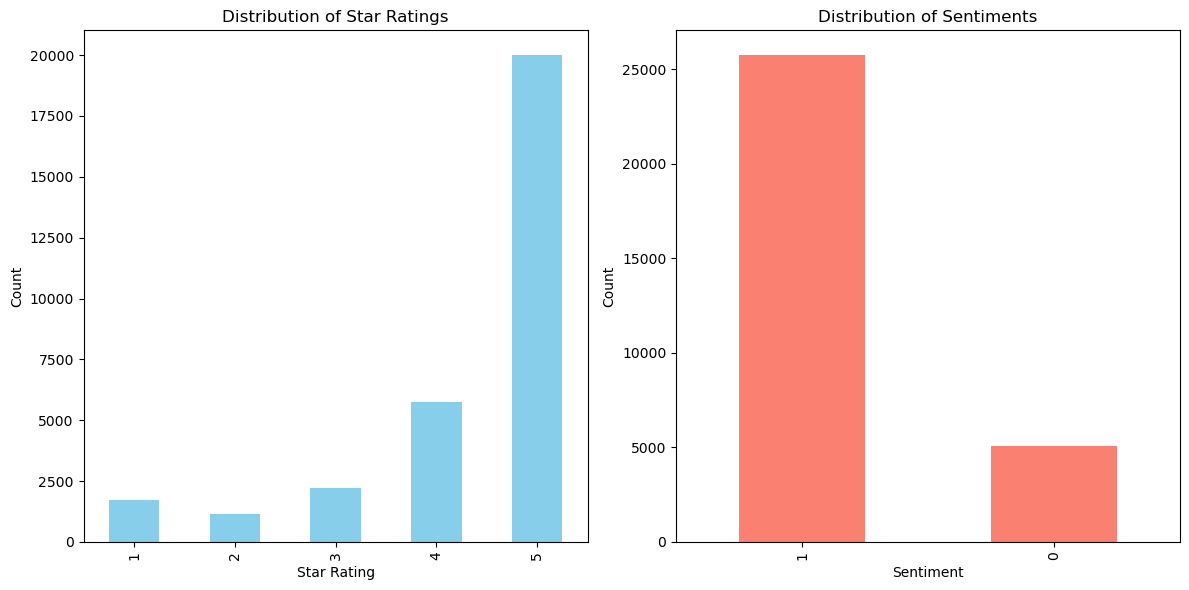

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['star_rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['sentiment'].value_counts().plot(kind='bar', color='salmon')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


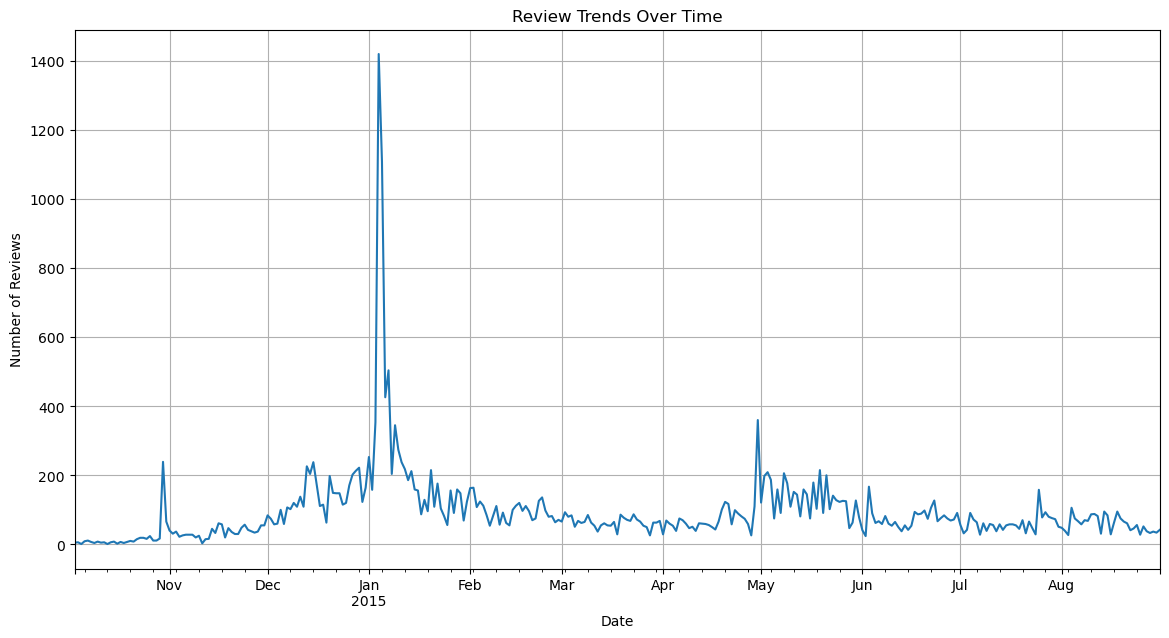

In [115]:
reviews_per_date = df.groupby('review_date').size()

plt.figure(figsize=(14, 7))
reviews_per_date.plot()
plt.title('Review Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()


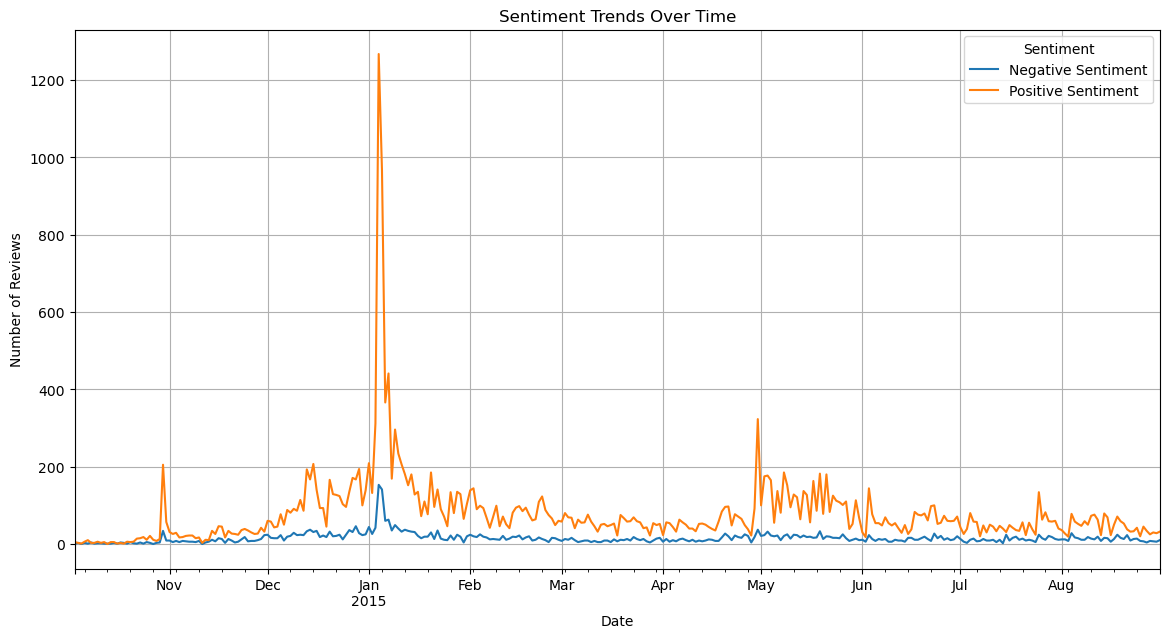

In [117]:
sentiment_trends = df.groupby(['review_date', 'sentiment']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
sentiment_trends.plot(kind='line', ax=plt.gca())
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.legend(['Negative Sentiment', 'Positive Sentiment'], title='Sentiment')
plt.grid(True)
plt.show()


In [119]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'<br\s*/?>', ' ', text)  # Replace <br> tags with space
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
        text = text.lower()  # Convert to lowercase
        return text
    else:
        return ""

df['cleaned_review_body'] = df['review_body'].apply(clean_text)


In [120]:
all_text = ' '.join(df['cleaned_review_body'])

In [122]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment,cleaned_review_body
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1,great love it
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0,lots of ads slow processing speed occasionally...
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1,excellent unit the versatility of this tablet...
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1,i bought this on amazon prime so i ended up bu...
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1,all amazon products continue to meet my expect...


In [126]:
df['product_category'].value_counts()

product_category
PC    30846
Name: count, dtype: int64

In [128]:
df['word_count'] = df['review_body'].apply(lambda x: len(str(x).split()))
avg_length_sentiment = df.groupby('sentiment')['word_count'].mean()
avg_length_star_rating = df.groupby('star_rating')['word_count'].mean()
avg_length_sentiment, avg_length_star_rating

(sentiment
 0    65.751723
 1    27.027167
 Name: word_count, dtype: float64,
 star_rating
 1    69.929157
 2    74.715152
 3    57.860108
 4    38.625957
 5    23.696838
 Name: word_count, dtype: float64)

Text(0, 0.5, 'Average Word Count')

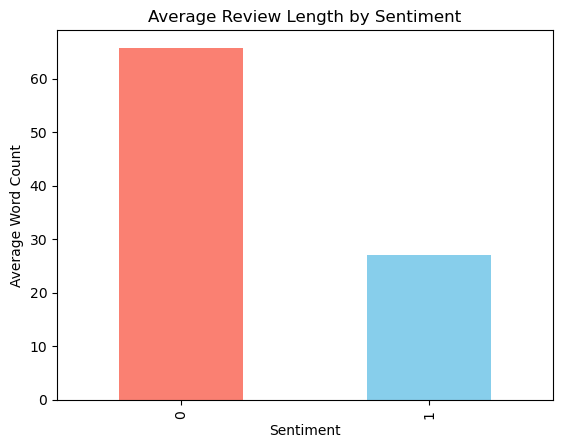

In [130]:
avg_length_sentiment.plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Average Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Word Count')

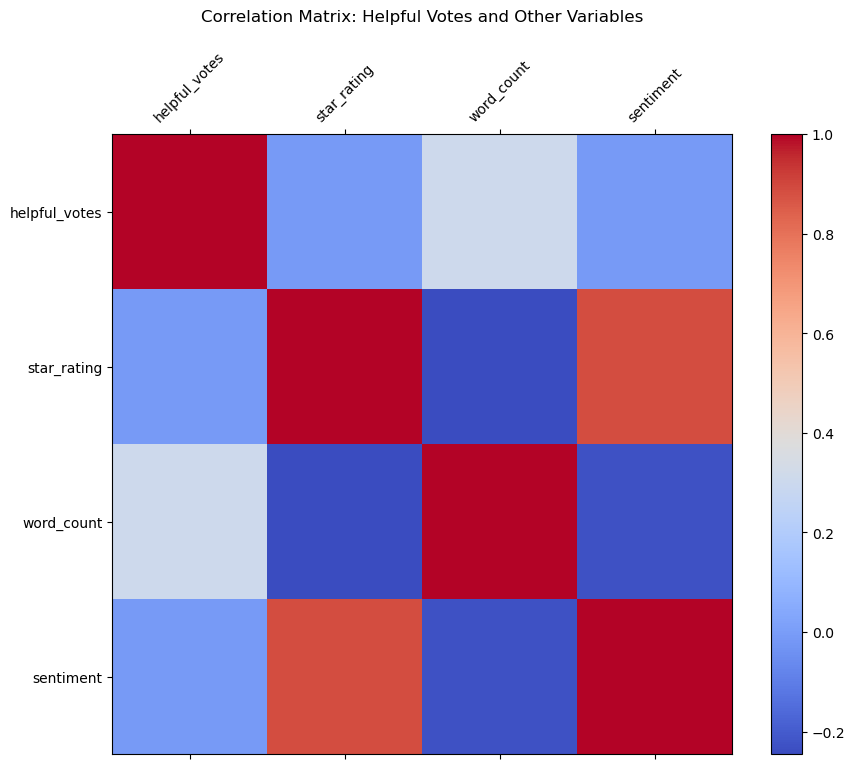

,helpful_votes,star_rating,word_count,sentiment
helpful_votes,1.000000,-0.011161,0.304493,-0.009823
star_rating,-0.011161,1.000000,-0.245388,0.885863
word_count,0.304493,-0.245388,1.000000,-0.229389
sentiment,-0.009823,0.885863,-0.229389,1.000000


In [132]:
# Calculate the correlation between helpful votes and other variables
correlation_matrix_helpful_votes = df[['helpful_votes', 'star_rating', 'word_count', 'sentiment']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix_helpful_votes, fignum=1, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(correlation_matrix_helpful_votes.columns)), correlation_matrix_helpful_votes.columns, rotation=45)
plt.yticks(range(len(correlation_matrix_helpful_votes.columns)), correlation_matrix_helpful_votes.columns)
plt.title('Correlation Matrix: Helpful Votes and Other Variables', pad=20)
plt.show()

correlation_matrix_helpful_votes


#### The strongest correlation observed is with the word count. Longer reviews are more likely to be found helpful, which makes sense as they generally contain more detailed and comprehensive information.

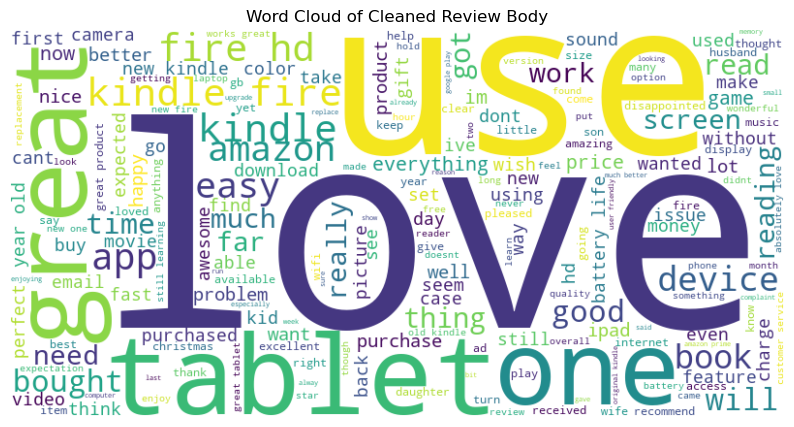

In [135]:
all_cleaned_text = ' '.join(df['cleaned_review_body'])
wordcloud_cleaned_review_body = WordCloud(width=800, height=400, background_color='white').generate(all_cleaned_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_cleaned_review_body, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Review Body')
plt.show()


#### The word cloud reveals that most reviews are positive, focusing on the love for the product and its great features.

In [137]:
df.to_csv("C:/Users/madhu/Downloads/Sentiment Analysis/clean_data.csv")

# Pre-Processing

In [139]:
df['cleaned_review_body']

0                                            great love it
1        lots of ads slow processing speed occasionally...
2        excellent unit  the versatility of this tablet...
3        i bought this on amazon prime so i ended up bu...
4        all amazon products continue to meet my expect...
                               ...                        
30841    videoidmopbgsrllyi purchased the original kind...
30842    im writing this review with the benefit of bei...
30843    i purchased this kindle for my grandma because...
30844    i bought my tablet fire hd  at best buy on the...
30845    am impressive piece of hardware for the  no re...
Name: cleaned_review_body, Length: 30846, dtype: object

In [140]:
# Check for NaN values in the text data
df.isna().sum()

marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          0
product_category       0
star_rating            0
helpful_votes          0
total_votes            0
vine                   0
verified_purchase      0
review_headline        2
review_body            4
review_date            0
sentiment              0
cleaned_review_body    0
word_count             0
dtype: int64

In [141]:
df['cleaned_review_body'].value_counts()

cleaned_review_body
love it                                                                                                                                                                                                                            1198
i love it                                                                                                                                                                                                                           318
great                                                                                                                                                                                                                               245
awesome                                                                                                                                                                                                                             168
great product                                       

In [142]:
df['cleaned_review_body']

0                                            great love it
1        lots of ads slow processing speed occasionally...
2        excellent unit  the versatility of this tablet...
3        i bought this on amazon prime so i ended up bu...
4        all amazon products continue to meet my expect...
                               ...                        
30841    videoidmopbgsrllyi purchased the original kind...
30842    im writing this review with the benefit of bei...
30843    i purchased this kindle for my grandma because...
30844    i bought my tablet fire hd  at best buy on the...
30845    am impressive piece of hardware for the  no re...
Name: cleaned_review_body, Length: 30846, dtype: object

In [144]:
df['cleaned_review_body'].isnull().sum()

0

In [145]:
#Check for duplicates
df['review_id'].duplicated().value_counts()

review_id
False    30846
Name: count, dtype: int64

In [153]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [155]:
sw = stopwords.words('english')
df['cleaned_review_body'] = df['cleaned_review_body'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [156]:
df['cleaned_review_body']

0                                               great love
1        lots ads slow processing speed occasionally sh...
2        excellent unit versatility tablet besides comp...
3        bought amazon prime ended buying gb one camera...
4               amazon products continue meet expectations
                               ...                        
30841    videoidmopbgsrllyi purchased original kindle f...
30842    im writing review benefit experienced kindle f...
30843    purchased kindle grandma wanted simple way vid...
30844    bought tablet fire hd best buy day came hadnt ...
30845    impressive piece hardware regrets girlfriend l...
Name: cleaned_review_body, Length: 30846, dtype: object

In [157]:
nltk.download('wordnet')
nltk.download('omw-1.4')
df['Review'] = df['cleaned_review_body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [158]:
df['cleaned_review_body']

0                                               great love
1        lots ads slow processing speed occasionally sh...
2        excellent unit versatility tablet besides comp...
3        bought amazon prime ended buying gb one camera...
4               amazon products continue meet expectations
                               ...                        
30841    videoidmopbgsrllyi purchased original kindle f...
30842    im writing review benefit experienced kindle f...
30843    purchased kindle grandma wanted simple way vid...
30844    bought tablet fire hd best buy day came hadnt ...
30845    impressive piece hardware regrets girlfriend l...
Name: cleaned_review_body, Length: 30846, dtype: object

In [159]:
tf = df["cleaned_review_body"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [162]:
tf.columns = ["words", "tf"]
tf_sorted = tf.sort_values(by='tf', ascending=False)
tf_sorted

,words,tf
92,kindle,11146.0
1,love,10922.0
49,fire,8928.0
0,great,7300.0
81,one,5757.0
...,...,...
10217,questionanswer,1.0
10218,nonchild,1.0
10219,resolutionneeds,1.0
10220,kg,1.0


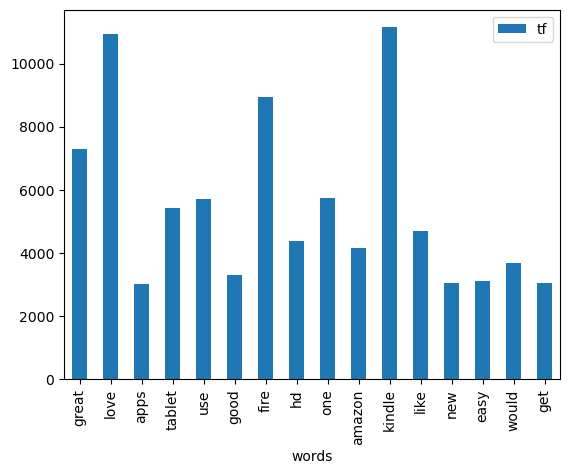

In [165]:
tf[tf["tf"] > 3000].plot.bar(x="words", y="tf")
plt.show()

In [166]:
tf[tf['tf'] == 1]

,words,tf
29,copiers,1.0
30,reams,1.0
32,farwell,1.0
35,inks,1.0
54,competitively,1.0
...,...,...
17719,utah,1.0
17720,utilitarian,1.0
17721,sexiest,1.0
17722,accord,1.0


In [167]:
tf[tf["tf"] == 1].count()

words    9498
tf       9498
dtype: int64

In [168]:
df['review_id'].count()

30846

In [169]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [170]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment,cleaned_review_body,word_count,Review
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1,great love,3,great love
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0,lots ads slow processing speed occasionally sh...,26,lot ad slow processing speed occasionally shut...
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1,excellent unit versatility tablet besides comp...,113,excellent unit versatility tablet besides comp...
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1,bought amazon prime ended buying gb one camera...,207,bought amazon prime ended buying gb one camera...
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1,amazon products continue meet expectations,8,amazon product continue meet expectation


In [171]:
df['cleaned_review_body'][df['sentiment'] == 0][0:10]

1     lots ads slow processing speed occasionally sh...
20    nice tablet disappointed see deliberately made...
21    dont waste money buying kindle fire hd youll b...
22    still slow glitchy first edition fire still fl...
25                            doesnt much space thought
27                                            learn use
35    wont stay connected wifi constantly log matter...
36    unit came directions use kind dont know use gu...
40    good value operating system little buggy perio...
41    find easy use regular kindle fire reading kind...
Name: cleaned_review_body, dtype: object

In [172]:
df["Review"]
sia = SentimentIntensityAnalyzer()
df['cleaned_review_body'][df['sentiment'] == 0][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

1     0.0000
20   -0.0772
21    0.7824
22   -0.8858
25    0.0000
27    0.0000
35    0.0258
36    0.5267
40    0.6486
41   -0.2023
Name: cleaned_review_body, dtype: float64

In [173]:
df['cleaned_review_body'][df['sentiment'] == 0][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

1     neg
20    neg
21    pos
22    neg
25    neg
27    neg
35    pos
36    pos
40    pos
41    neg
Name: cleaned_review_body, dtype: object

In [174]:
df["polarity_score"] = df['cleaned_review_body'].apply(lambda x: sia.polarity_scores(x)["compound"])

In [175]:
k = df[['sentiment','cleaned_review_body','polarity_score']]

In [176]:
k['reaction'] = k['polarity_score'].apply(lambda x: "pos" if x > 0.85 else ("neg" if x < 0.85 else "neu"))

In [177]:
k[(k['sentiment'] == 1) & (k['reaction'] == 'neg')]


,sentiment,cleaned_review_body,polarity_score,reaction
4,1,amazon products continue meet expectations,0.1779,neg
5,1,good product like,0.6597,neg
6,1,kindle works well battery goes dead quickly yo...,0.7501,neg
8,1,wanted performs perfectly everything works gre...,0.8481,neg
9,1,made well like looks style,0.5574,neg
...,...,...,...,...
30828,1,would great working windows transfer driver in...,0.5859,neg
30832,1,love far,0.6369,neg
30834,1,resolution isnt great good enough videos play ...,-0.7654,neg
30840,1,one step forward one back owned earlier hd lov...,-0.5282,neg


# Modeling

In [215]:
import logging
logging.basicConfig(level=logging.ERROR)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, model_max_length=512, truncation=True)
input_ids = []
attention_masks = []

for review in df['cleaned_review_body']:
    encoded_dict = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True,  # Explicitly set truncation to True
        return_tensors='tf',
    )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = np.asarray(input_ids).squeeze()
attention_masks = np.asarray(attention_masks).squeeze()
labels = pd.get_dummies(df['sentiment']).values
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, test_size=0.3)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.3)


In [217]:
n_cols = input_ids.shape[1]
input_shape = (n_cols,)

# Specify the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape = input_shape))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)
# Fit the model

hist = model.fit(input_ids,labels,callbacks = [early_stopping_monitor],validation_split = 0.3,epochs=30)
# different parameter tuning on different levels

Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7417 - loss: 153.2609 - val_accuracy: 0.7677 - val_loss: 33.8951
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7558 - loss: 26.1446 - val_accuracy: 0.8290 - val_loss: 22.4926
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.7646 - loss: 12.4922 - val_accuracy: 0.7175 - val_loss: 13.6485
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.7691 - loss: 7.2297 - val_accuracy: 0.7846 - val_loss: 5.5891
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.7707 - loss: 4.0205 - val_accuracy: 0.7694 - val_loss: 4.1966
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7746 - loss: 3.2339 - val_accuracy: 0.7955 - val_loss: 3.2502
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - accuracy: 0.7738 - loss: 2.3368 - val_accuracy: 0.8133 - val_loss: 2.7400
Epoch 8/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - accuracy: 0.7798 - loss: 1.8865 -

In [219]:
results = model.evaluate([validation_inputs, validation_masks], validation_labels)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.8470 - loss: 0.4376
Test Loss: 0.44790253043174744
Test Accuracy: 0.8444996476173401


### Parameter Tuning

In [295]:
from keras.layers import Dense, LeakyReLU
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

labels = np.argmax(pd.get_dummies(df['sentiment']).values, axis=1)

def create_model(neurons=10, activation='relu', optimizer='adam', learning_rate=0.001):
    optimizerL = {
        'adam': Adam(learning_rate=learning_rate), 'sgd': SGD(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate), 'adadelta': Adadelta(learning_rate=learning_rate),
        'adagrad': Adagrad(learning_rate=learning_rate), 'adamax': Adamax(learning_rate=learning_rate),
        'nadam': Nadam(learning_rate=learning_rate), 'ftrl': Ftrl(learning_rate=learning_rate)
    }
    activationL = {
        'relu': 'relu', 'sigmoid': 'sigmoid', 'softplus': 'softplus', 'softsign': 'softsign',
        'tanh': 'tanh', 'selu': 'selu', 'elu': 'elu', 'exponential': 'exponential', 'leaky_relu': LeakyReLU()
    }
    
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_ids.shape[1], activation=activationL[activation]))
    model.add(Dense(neurons, activation=activationL[activation]))
    model.add(Dense(1, activation='sigmoid'))  # Single unit for binary classification
    
    model.compile(loss='binary_crossentropy', optimizer=optimizerL[optimizer], metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0, activation='relu', learning_rate=0.001, neurons=10)

param_grid = {
    'neurons': [10, 50, 100],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'epochs': [50, 100]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)

grid_result = grid.fit(input_ids, labels)

print(f"Best Score: {grid_result.best_score_}")
print(f"Best Parameters: {grid_result.best_params_}")


Best Score: 0.837223627050509
Best Parameters: {'activation': 'sigmoid', 'batch_size': 128, 'epochs': 50, 'learning_rate': 0.001, 'neurons': 100, 'optimizer': 'sgd'}


# Modeling Using Machine Learning Models

In [72]:
train_x, test_x, train_y, test_y = train_test_split(df["cleaned_review_body"],
                                                    df["sentiment"],
                                                    random_state=42)

In [73]:
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [74]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 2)).fit(train_x)
x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(train_x)
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(test_x)

In [77]:
log_model_word = LogisticRegression().fit(x_train_tf_idf_word, train_y)
y_pred_word = log_model_word.predict(x_test_tf_idf_word)

print(classification_report(y_pred_word, test_y))

              precision    recall  f1-score   support

           0       0.55      0.77      0.65       904
           1       0.97      0.92      0.94      6808

    accuracy                           0.90      7712
   macro avg       0.76      0.85      0.79      7712
weighted avg       0.92      0.90      0.91      7712



In [78]:
# Cross Validation
cross_val_score(log_model_word, x_test_tf_idf_word, test_y, cv=5).mean()

0.881871940809631

In [79]:
random_review = pd.Series(df["cleaned_review_body"].sample(1).values)
new_comment = CountVectorizer().fit(train_x).transform(random_review)
pred = log_model_word.predict(new_comment)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  works great handy 
 Prediction: [1]


In [80]:
log_model_ngram = LogisticRegression().fit(x_train_tf_idf_ngram, train_y)
y_pred_ngram = log_model_ngram.predict(x_test_tf_idf_ngram)

print(classification_report(y_pred_ngram, test_y))

              precision    recall  f1-score   support

           0       0.10      0.78      0.17       158
           1       0.99      0.85      0.92      7554

    accuracy                           0.85      7712
   macro avg       0.55      0.81      0.54      7712
weighted avg       0.98      0.85      0.90      7712



In [81]:
# Cross Validation
cross_val_score(log_model_ngram, x_test_tf_idf_ngram, test_y, cv=5).mean()

0.8367480265253817

In [82]:
# Randomly selecting comments from the data and asking them to the model
random_review = pd.Series(df["Review"].sample(1).values)
new_comment = tf_idf_ngram_vectorizer.transform(random_review)
pred = log_model_ngram.predict(new_comment)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  great love 
 Prediction: [1]


In [83]:
# Modelling (Random Forest)
rf_model_word = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
print(classification_report(y_pred_word, test_y))

              precision    recall  f1-score   support

           0       0.55      0.77      0.65       904
           1       0.97      0.92      0.94      6808

    accuracy                           0.90      7712
   macro avg       0.76      0.85      0.79      7712
weighted avg       0.92      0.90      0.91      7712



In [84]:
cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.8641073489496517

In [85]:
rf_model_ngram = RandomForestClassifier().fit(x_train_tf_idf_ngram, train_y)
y_pred_ngram = rf_model_ngram.predict(x_test_tf_idf_ngram)
print(classification_report(test_y, y_pred_ngram))

              precision    recall  f1-score   support

           0       0.74      0.22      0.34      1262
           1       0.87      0.98      0.92      6450

    accuracy                           0.86      7712
   macro avg       0.80      0.60      0.63      7712
weighted avg       0.84      0.86      0.83      7712



In [86]:
cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=5, n_jobs=-1).mean()

0.8390821525268292

In [87]:
random_review = pd.Series(df["cleaned_review_body"].sample(1).values)
new_comment = CountVectorizer().fit(train_x).transform(random_review)
pred = rf_model_word.predict(new_comment)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  love tablet clear display easy use 
 Prediction: [1]


In [88]:
random_review = pd.Series(df['cleaned_review_body'][df['sentiment'] == 0][0:10].sample(1).values)
new_comment = CountVectorizer().fit(train_x).transform(random_review)
pred = rf_model_word.predict(new_comment)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  unit came directions use kind dont know use guess buy kindle 
 Prediction: [0]


### Modeling Approach
The modeling phase involved using various machine learning algorithms to predict the sentiment of Amazon product reviews. The primary goal was to classify reviews into positive or negative sentiment based on the review text.

### Observations
#### Logistic Regression:

Performed exceptionally well with word-level TF-IDF features.
High precision and recall for positive reviews.
N-gram features also provided good performance but slightly lower accuracy compared to word-level features.

#### Random Forest Classifier:

Showed moderate performance.
Better performance with n-gram features than word-level TF-IDF.
Precision and recall were lower compared to logistic regression, indicating potential overfitting.

#### Conclusion
Logistic regression with word-level TF-IDF vectorization was the best-performing model with an accuracy of 90%.
The model's high precision and recall for positive sentiment make it a reliable classifier for determining customer sentiment.
Future work can involve hyperparameter tuning, exploring other models like SVM, and using more complex deep learning techniques to potentially improve performance further.